Round 200  total->100	 won->9	 lost->68	 tie->23
Round 400  total->100	 won->16	 lost->56	 tie->28
Round 600  total->100	 won->8	 lost->51	 tie->41
Round 800  total->100	 won->14	 lost->38	 tie->48
Round 1000  total->100	 won->16	 lost->36	 tie->48
Round 1200  total->100	 won->30	 lost->27	 tie->43
Round 1400  total->100	 won->37	 lost->27	 tie->36
Round 1600  total->100	 won->26	 lost->31	 tie->43
Round 1800  total->100	 won->35	 lost->30	 tie->35
Round 2000  total->100	 won->50	 lost->28	 tie->22
Round 2200  total->100	 won->45	 lost->25	 tie->30
Round 2400  total->100	 won->38	 lost->33	 tie->29
Round 2600  total->100	 won->35	 lost->33	 tie->32
Round 2800  total->100	 won->37	 lost->21	 tie->42
Round 3000  total->100	 won->45	 lost->20	 tie->35
Round 3200  total->100	 won->36	 lost->26	 tie->38
Round 3400  total->100	 won->51	 lost->13	 tie->36
Round 3600  total->100	 won->25	 lost->24	 tie->51
Round 3800  total->100	 won->45	 lost->17	 tie->38
Round 4000  total->100	 won->51	 lost

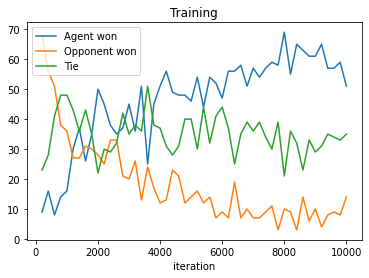

 total->1000	 won->566	 lost->86	 tie->348
Test time performance ---- played->1000	 won->566	 lost->86	 tie->348


In [ ]:
# Assumption Player 1 is our RL agent, Player 2 is one of the three opponenet
# act method is in Player class
# print_board prints the current state of the board, it's in Board class



import numpy as np
import copy
import matplotlib.pyplot as plt
np.random.seed(0)

class Player(object):
    def __init__(self,name,changes_each_game = False):
        self.name = name
        self.states_visited = []
        self.changes_each_game = changes_each_game
        self.Q_table = {}

        self.ephsilon = 0.3
        self.gamma = 0.9
        self.alpha = 0.2

    def state_to_str(self,grid):
        return str(grid.reshape(3*3))

    def add_visited(self,state):
        self.states_visited.append(state)

    def update_Q_table(self,maxQnext):
        for state in self.states_visited[::-1]:
            if self.Q_table.get(state) == None:
                self.Q_table[state] = 0
            self.Q_table[state] = self.Q_table[state] + self.alpha*(self.gamma*maxQnext-self.Q_table[state])
            maxQnext = self.Q_table[state]

    def reset(self):
        self.states_visited = []
        if self.changes_each_game:
            self.name = ("random" if np.random.uniform() < 0.5 else "safe")

    def save_ploicy(self):
        Q_t = open("Q_table"+self.name,'wb')
        pickle.dump(self.Q_table,Q_t)
        Q_t.close()

    def load_policy(self,file):
        Q_t = open(file,'rb')
        self.Q_table = pickle.load(Q_t)
        Q_t.close

    def ephsilon_greedy(self,pos,grid,current_move):
        if np.random.uniform() < self.ephsilon: # exploration
            index = np.random.choice(len(pos))
            return pos[index]

        else:   # exploitation
            opt_action = None
            opt_val = float("-inf")
            for position in pos:
                next_state = copy.deepcopy(grid)
                next_state[position] = current_move
                next_state_str = self.state_to_str(next_state)
                if self.Q_table.get(next_state_str):
                    val = self.Q_table.get(next_state_str)
                else:
                    val = 0
                if val > opt_val:
                    opt_val = val
                    opt_action = position
            return opt_action # greedy action

    def random_action(self,pos,grid,current_move):
        return pos[np.random.choice(len(pos))]

    def winner(self,grid):
        # check rows
        for i in range(3):
            if np.sum(grid[i,:]) == 3:
                return 1
            elif np.sum(grid[i,:]) == -3:
                return -1
        # check columns
        for j in range(3):
            if np.sum(grid[:,j]) == 3:
                return 1
            elif np.sum(grid[:,j]) == -3:
                return -1
        # check diagonals
        diagsum = np.sum([grid[i][i] for i in range(3)])
        if diagsum == 3:
            return 1
        if diagsum == -3:
            return -1
        diagsum = np.sum([grid[0][2],grid[1][1],grid[2][0]])
        if diagsum == 3:
            return 1
        if diagsum ==-3:
            return -1
        
        # check ties
        if len([(i,j) for i in range(3) for j in range(3) if grid[i][j] == 0]) == []:
            self.game_over = True
            return 0

        return None

    def safe_action(self,pos,grid,current_move):
        # checks if can win
        for position in pos:
            next_state = copy.deepcopy(grid)
            next_state[position] = current_move
            if self.winner(next_state) == -1:
                return position
        # checks if can block
        for position in pos:
            next_state = copy.deepcopy(grid)
            next_state[position] = (1 if current_move == -1 else -1)
            if self.winner(next_state) == 1:
                return position
        # else random action
        return pos[np.random.choice(len(pos))]

    def greedy(self,pos,grid,current_move):
        # takes greedy action wrt current Q table
        greedy_action = None
        opt_val = float("-inf")
        for position in pos:
            next_state = copy.deepcopy(grid)
            next_state[position] = current_move
            next_state_str = self.state_to_str(next_state)
            if self.Q_table.get(next_state_str):
                val = self.Q_table.get(next_state_str)
            else:
                val = 0
            if val > opt_val:
                opt_val = val
                opt_action = position
        return opt_action # greedy action

    def act(self,agent,pos,grid,current_move):
        if agent == "random":
            return self.random_action(pos,grid,current_move)
        elif agent == "safe":
            return self.safe_action(pos,grid,current_move)
        elif agent == "RL":
            return self.ephsilon_greedy(pos,grid,current_move)
        elif agent == "test":
            return self.greedy(pos,grid,current_move)

class Board(object):
    def __init__(self,p1,p2):
        self.grid = np.zeros((3,3))
        self.p1 = p1
        self.p2 = p2
        self.game_over = False
        # tossing coin for first move
        self.current_move = (1 if np.random.uniform() < 0.5 else -1)

        # plot helpers
        self.won = []
        self.lost = []
        self.tie = []
        self.iter = []

    def state_to_str(self):
        return str(self.grid.reshape(3*3))

    def winner(self):
        # check rows
        for i in range(3):
            if np.sum(self.grid[i,:]) == 3:
                self.game_over = True
                return 1
            elif np.sum(self.grid[i,:]) == -3:
                self.game_over = True
                return -1
        # check columns
        for j in range(3):
            if np.sum(self.grid[:,j]) == 3:
                self.game_over = True
                return 1
            elif np.sum(self.grid[:,j]) == -3:
                self.game_over = True
                return -1
        # check diagonals
        diagsum = np.sum([self.grid[i][i] for i in range(3)])
        if diagsum == 3:
            self.game_over = True
            return 1
        if diagsum == -3:
            self.game_over = True
            return -1
        diagsum = np.sum([self.grid[0][2],self.grid[1][1],self.grid[2][0]])
        if diagsum == 3:
            self.game_over = True
            return 1
        if diagsum ==-3:
            self.game_over = True
            return -1

        # check ties
        if self.available_positions() == []:
            self.game_over = True
            return 0

        return None

    def available_positions(self):
        pos = [(i,j) for i in range(3) for j in range(3) if self.grid[i][j] == 0]
        return pos

    def update_grid(self,position):
        self.grid[position] = self.current_move
    
    def switch_player(self):
        self.current_move = (1 if self.current_move == -1 else -1)

    def distribute_reward(self):
        winner = self.winner()
        if winner == 1:
            self.p1.update_Q_table(1)
        elif winner == -1:
            self.p1.update_Q_table(0)
        else:
            self.p1.update_Q_table(0.1)

    def reset(self):
        self.grid = np.zeros((3,3))
        self.game_over = False
        # tossing coin for first move
        self.current_move = (1 if np.random.uniform() < 0.5 else -1)

    def print_board(self):
        def numtochar(v):
            if v==1:
                return "X"
            elif v == -1:
                return "O"
            else:
                return " "
        for i in range(3):
            print(numtochar(self.grid[i][0]),"|",numtochar(self.grid[i][1]),"|",numtochar(self.grid[i][2]))
            if i != 2:
                print("_","|","_","|","_")
        print("-------------")

    def play(self,count=10000):
        for i in range(count):
            if (i+1)%200 == 0:
                print("Round {}".format(i+1), end = " ")
                self.iter.append(i+1)
                self.test()
            while self.game_over == False:
                if self.current_move == 1: # player 1
                    pos = self.available_positions()
                    action = self.p1.act(self.p1.name,pos,self.grid,self.current_move)
                    self.update_grid(action)
                    self.switch_player()
                    new_state = self.state_to_str()
                    self.p1.add_visited(new_state)

                    if self.winner() != None:
                        self.distribute_reward()
                        self.p1.reset()
                        self.p2.reset()
                        break

                else:
                    pos = self.available_positions()
                    action = self.p2.act(self.p2.name,pos,self.grid,self.current_move)
                    self.update_grid(action)
                    self.switch_player()
                    if self.winner() != None:
                        self.distribute_reward()
                        self.p1.reset()
                        self.p2.reset()
                        break
            self.reset()
        plt.plot(self.iter,self.won)
        plt.plot(self.iter,self.lost)
        plt.plot(self.iter,self.tie)
        plt.xlabel("iteration")
        plt.legend(["Agent won","Opponent won", "Tie"])
        plt.title("Training")
        plt.show()


        # test for 1000 games after training
        self.won = []
        self.lost = []
        self.tie = []
        self.test(1000)
        print("Test time performance ---- played->{}\t won->{}\t lost->{}\t tie->{}".format(1000,self.won[0],self.lost[0],self.tie[0]))


    def test(self,count = 100):
        won = 0
        lost = 0
        tie = 0
        self.reset()
        self.p1.reset()
        self.p2.reset()
        for i in range(count):
            while self.game_over == False:
                # self.print_board()

                if self.current_move == 1: # player 1
                    pos = self.available_positions()
                    action = self.p1.act("test",pos,self.grid,self.current_move)
                    self.update_grid(action)
                    self.switch_player()
                    if self.winner() != None:
                        if self.winner() == 1:
                            won+=1
                        elif self.winner() == -1:
                            lost += 1
                        else:
                            tie += 1
                        self.p1.reset()
                        self.p2.reset()
                        break

                else:
                    pos = self.available_positions()
                    action = self.p2.act(self.p2.name,pos,self.grid,self.current_move)
                    self.update_grid(action)
                    self.switch_player()
                    if self.winner() != None:
                        if self.winner() == 1:
                            won+=1
                        elif self.winner() == -1:
                            lost += 1
                        else:
                            tie += 1
                        self.p1.reset()
                        self.p2.reset()
                        break
                
            self.reset()


        print(" total->{}\t won->{}\t lost->{}\t tie->{}".format(count,won,lost,tie))
        self.won.append(won)
        self.lost.append(lost)
        self.tie.append(tie)



# training and testing against safe agent
if __name__ == "__main__":
    p1 = Player("RL")
    p2 = Player("safe")

    board = Board(p1,p2)
    board.play()

    

Round 200  total->100	 won->56	 lost->38	 tie->6
Round 400  total->100	 won->56	 lost->39	 tie->5
Round 600  total->100	 won->68	 lost->28	 tie->4
Round 800  total->100	 won->62	 lost->31	 tie->7
Round 1000  total->100	 won->72	 lost->24	 tie->4
Round 1200  total->100	 won->80	 lost->16	 tie->4
Round 1400  total->100	 won->75	 lost->19	 tie->6
Round 1600  total->100	 won->76	 lost->20	 tie->4
Round 1800  total->100	 won->75	 lost->20	 tie->5
Round 2000  total->100	 won->70	 lost->20	 tie->10
Round 2200  total->100	 won->81	 lost->15	 tie->4
Round 2400  total->100	 won->76	 lost->21	 tie->3
Round 2600  total->100	 won->78	 lost->13	 tie->9
Round 2800  total->100	 won->76	 lost->17	 tie->7
Round 3000  total->100	 won->83	 lost->16	 tie->1
Round 3200  total->100	 won->80	 lost->17	 tie->3
Round 3400  total->100	 won->80	 lost->18	 tie->2
Round 3600  total->100	 won->85	 lost->10	 tie->5
Round 3800  total->100	 won->88	 lost->9	 tie->3
Round 4000  total->100	 won->81	 lost->15	 tie->4
Roun

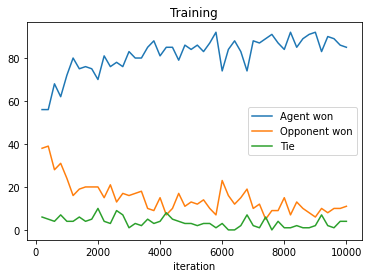

 total->1000	 won->871	 lost->99	 tie->30
Test time performance ---- played->1000	 won->871	 lost->99	 tie->30


In [ ]:
# training and testing against random agent
if __name__ == "__main__":
    p1 = Player("RL")
    p2 = Player("random")

    board = Board(p1,p2)
    board.play()

Round 200  total->100	 won->35	 lost->55	 tie->10
Round 400  total->100	 won->42	 lost->45	 tie->13
Round 600  total->100	 won->39	 lost->51	 tie->10
Round 800  total->100	 won->35	 lost->52	 tie->13
Round 1000  total->100	 won->44	 lost->43	 tie->13
Round 1200  total->100	 won->42	 lost->48	 tie->10
Round 1400  total->100	 won->49	 lost->32	 tie->19
Round 1600  total->100	 won->52	 lost->37	 tie->11
Round 1800  total->100	 won->51	 lost->40	 tie->9
Round 2000  total->100	 won->49	 lost->39	 tie->12
Round 2200  total->100	 won->54	 lost->38	 tie->8
Round 2400  total->100	 won->56	 lost->29	 tie->15
Round 2600  total->100	 won->58	 lost->27	 tie->15
Round 2800  total->100	 won->46	 lost->41	 tie->13
Round 3000  total->100	 won->57	 lost->38	 tie->5
Round 3200  total->100	 won->56	 lost->31	 tie->13
Round 3400  total->100	 won->62	 lost->32	 tie->6
Round 3600  total->100	 won->66	 lost->30	 tie->4
Round 3800  total->100	 won->48	 lost->43	 tie->9
Round 4000  total->100	 won->64	 lost->25

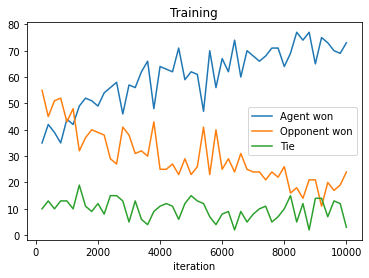

 total->1000	 won->728	 lost->221	 tie->51
Test time performance ---- played->1000	 won->728	 lost->221	 tie->51


In [ ]:
# opponenet changes each game
if __name__ == "__main__":
    p1 = Player("RL")
    p2 = Player("random",changes_each_game = True)

    board = Board(p1,p2)
    board.play()

**Q4:** The third agent may be better than the first two, since it has both the characteristics of the first two agents.

**Q5:** No the agent is not ubeatable (at least not in the current state). But let's say that we have an agent that's doing very well against the above two agents, still we can make an agent that can look two steps ahead in the future and that will surely be a better agent than the current one.

references:


*   https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542
*   https://towardsdatascience.com/reinforcement-learning-explained-visually-part-4-q-learning-step-by-step-b65efb731d3e

